# R&D center WINSTARS.AI 
## Test task in Data Science
---

**Goal:** build a semantic segmentation model
**Dataset:** [link](https://www.kaggle.com/c/airbus-ship-detection/data)

### Segmentation in Image Processing
In image processing and computer vision image segmentation is a very important and useful task. It consists in partitioning the image into multiple segments, or sets of pixels that belong to a particular class. In particular the task is passing a particular label to every pixel in the image based on some shared characteristics, the results produces a mask, a set of segments that cover the entire or part of the image. The applications of this kind of machine learning task are huge for example in the medical imaging of face recognition.

There are two main segmentation approaches:

* Semantic Segmentation: all pixels belonging to a particular class are considered together as one mask.
* Instance Segmentation: the pixels are divided into different objects, even if belong to the same class.

In our case the problem is Instance Segmentation one, in particular we have to match every ship in the images and find the pixels belonging to that particular class.

### Libraries
All the libraries used in this notebook 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt


import os #to load the data
import random
import PIL.Image #manage images 
from skimage.io import imread, imshow, concatenate_images
from skimage import io, transform
from skimage.measure import label, regionprops

### Functions


In [2]:
#apply a particular mask over the image 
def apply_mask(image, mask):
    for x, y in mask:
        image[x, y, [0, 1]] = 255
    return image

In [3]:
def rle_to_pixels(rle_code):
    """
    Transforms RLE code string into a list of pixels of a (768, 768) canvas
    """
    # Divide the rle in a list of pairs of ints representing the (start,length)
    rle_code = [int(i) for i in rle_code.split()] 
    
    pixels = [
        #Find the 2d coordinate for the canvas using the mod function (%) and the integer division function(//)
        (pixel_position % 768, pixel_position // 768) 
        # I select the start pixel and the length of the line
                 for start, length in list(zip(rle_code[0:-1:2], rle_code[1::2])) 
        # I screen all the pixel positions representing (start,end)
                 for pixel_position in range(start, start + length)] 
    return pixels

## Exploratory Data Analysis

### Loading the Datasets

Are available two different datasets, one will be used for the training section. It is composed by 192556 different images in a .jpg format and a size of 768x768. The other dataset will be used for the test section, and it is composed by 15606 images with the same characteristics.

In [4]:
train = os.listdir("data/train_v2")
test = os.listdir("data/test_v2")
sub= pd.read_csv("data/sample_submission_v2.csv", index_col=0).dropna()

# Set paths
data_root = 'data'
path_train = os.path.join(data_root,'train_v2')
path_test = os.path.join(data_root,'test_v2')

print(f"Train files: {len(train)}. ---> {train[:3]}")
print(f"Test files :  {len(test)}. ---> {test[:3]}")

#PIL.Image.open("../input/airbus-ship-detection/train_v2/000c34352.jpg")
print("The dimension of the images is: "+str(PIL.Image.open("data/train_v2/000c34352.jpg").size))

Train files: 192556. ---> ['00003e153.jpg', '0001124c7.jpg', '000155de5.jpg']
Test files :  15606. ---> ['00002bd58.jpg', '00015efb6.jpg', '00023d5fc.jpg']
The dimension of the images is: (768, 768)


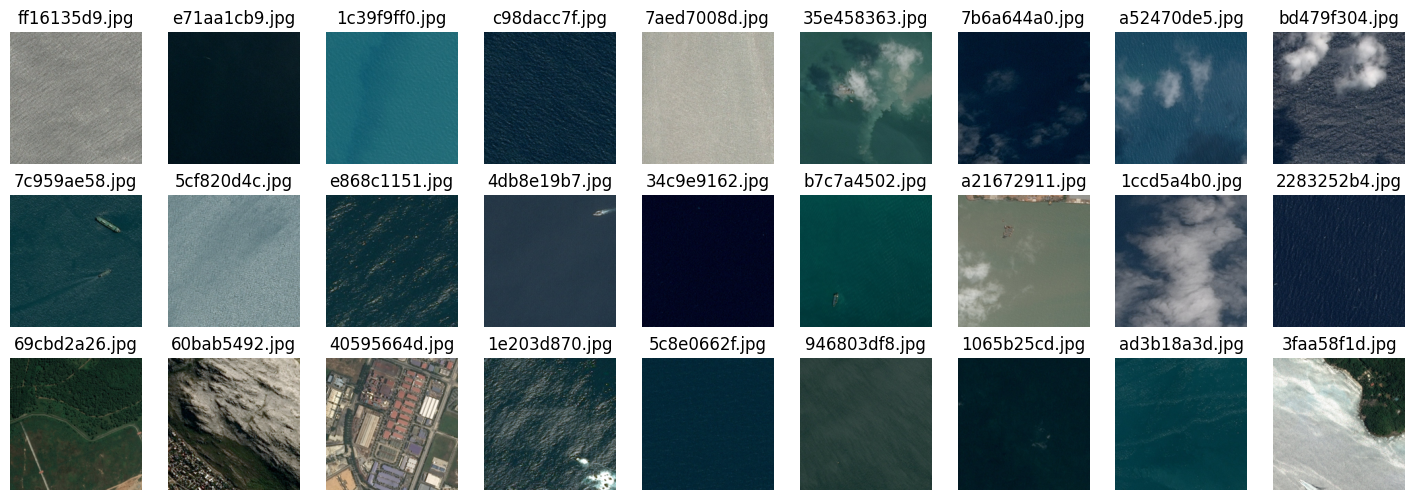

In [5]:
# Plot some images from the train set 
w = 9
h = 3

# we resize the format of the images with a 200x200 shape
# this function uses the open, resize and array functions to manage data visualizations
load_img = lambda filename: np.array(PIL.Image.open(f"data/train_v2/{filename}").resize((200, 200)))

_, axes_list = plt.subplots(h, w, figsize=(2*w, 2*h)) # define a grid of (w, h)

for axes in axes_list:
    for ax in axes:
        ax.axis('off')
        img = np.random.choice(train) # take a random train filename
        ax.imshow(load_img(img)) # load and show
        ax.set_title(img)

#### Run-length encoding
The encoded string looks like this: start, length, start, length, ... , where each pair of (start, length) draws a line of length pixels starting from position start. The start position, in turn, is not a (x, y) coordinate but an index of the 1-d array resulting of flattening the 2-d image into a rows-after-row 1-d sequence of pixels. Knowing the shape of the images we can just unfold this 1-d representation into a 2-dimensions mask using // and %.

We load this .cvs file and write some useful functions to better use the encoding.

In [6]:
df = pd.read_csv("data/train_ship_segmentations_v2.csv", index_col=0).dropna()
display(df.head())

print('Example of a encoding run-length format: \n')
df['EncodedPixels']['000155de5.jpg']

,EncodedPixels
ImageId,
000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...


Example of a encoding run-length format: 


'264661 17 265429 33 266197 33 266965 33 267733 33 268501 33 269269 33 270037 33 270805 33 271573 33 272341 33 273109 33 273877 33 274645 33 275413 33 276181 33 276949 33 277716 34 278484 34 279252 33 280020 33 280788 33 281556 33 282324 33 283092 33 283860 33 284628 33 285396 33 286164 33 286932 33 287700 33 288468 33 289236 33 290004 33 290772 33 291540 33 292308 33 293076 33 293844 33 294612 33 295380 33 296148 33 296916 33 297684 33 298452 33 299220 33 299988 33 300756 33 301524 33 302292 33 303060 33 303827 34 304595 34 305363 33 306131 33 306899 33 307667 33 308435 33 309203 33 309971 33 310739 33 311507 33 312275 33 313043 33 313811 33 314579 33 315347 33 316115 33 316883 33 317651 33 318419 33 319187 33 319955 33 320723 33 321491 33 322259 33 323027 33 323795 33 324563 33 325331 33 326099 33 326867 33 327635 33 328403 33 329171 33 329938 34 330706 34 331474 33 332242 33 333010 33 333778 33 334546 33 335314 33 336082 33 336850 33 337618 33 338386 33 339154 33 339922 33 340690 33

### Statistics about data

In [7]:
# Read CSV as dataframe
df_count = pd.read_csv(os.path.join('data/train_ship_segmentations_v2.csv'))
print('Total number of images (original): %d' % df_count['ImageId'].value_counts().shape[0])

# Create a dataframe with unique images id as indexes and number of ships and image sizes as new columns
df_count = df_count[~df_count['ImageId'].isin(['6384c3e78.jpg'])] # remove corrupted file 
unique_img_ids = df_count.groupby('ImageId').size().reset_index(name='counts')
print('Total number of images (after removing corrupted images): %d' % df_count['ImageId'].value_counts().shape[0])

Total number of images (original): 192556
Total number of images (after removing corrupted images): 192555


Number of images with ships :     42556 
Number of images without ships : 149999
  
Proportion: 0.3
 
Ration with ships:     0.22
Ration without ships:  0.78


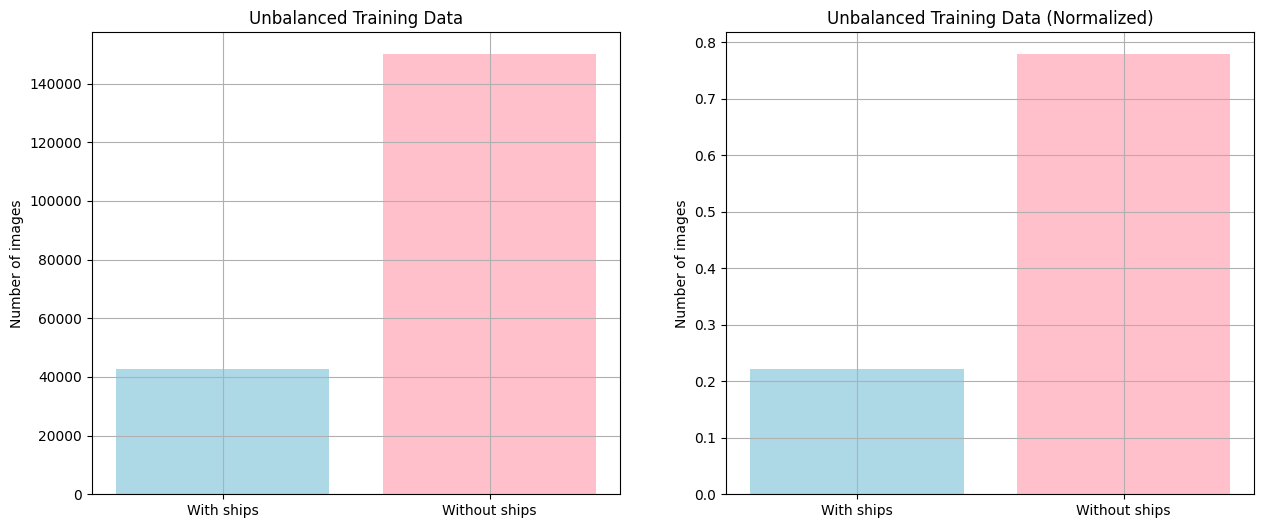

In [8]:
# Count number of ships per image
df_wships = df_count.dropna()
df_wships = df_wships.groupby('ImageId').size().reset_index(name='counts')
df_woships = df_count[df_count['EncodedPixels'].isna()]

print('Number of images with ships :     %d \nNumber of images without ships : %d\n  \nProportion: %0.1f\n ' \
      % (df_wships.shape[0], df_woships.shape[0], df_wships.shape[0] / df_woships.shape[0]))


print('Ration with ships:     ' +str(round((df_wships.shape[0]/len(train)),2)))
print('Ration without ships:  ' +str(round((df_woships.shape[0]/len(train)),2)))

#make plots

plt.figure(figsize=(15, 6))

plt.subplot(1,2,1)
plt.bar(['With ships','Without ships'], [len(df_wships),len(df_woships)], color = ['lightblue','pink'])
plt.ylabel('Number of images')
plt.title('Unbalanced Training Data')
plt.grid()

plt.subplot(1,2,2)
plt.bar(['With ships','Without ships'], [len(df_wships)/len(train),len(df_woships)/len(train)], 
        color = ['lightblue','pink'])
plt.ylabel('Number of images')
plt.title('Unbalanced Training Data (Normalized)')
plt.grid()

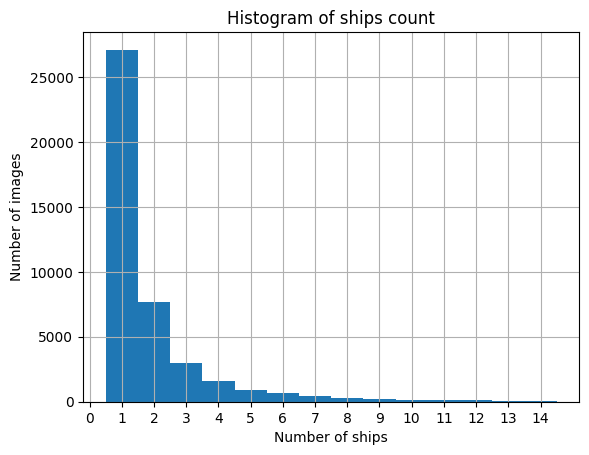

In [9]:
# Plot histogram
hist = df_wships.hist(bins=np.arange(df_wships['counts'].max())+0.5)
plt.xticks(range(15))
plt.title("Histogram of ships count")
plt.xlabel("Number of ships")
plt.ylabel("Number of images")
plt.show(hist)

In [10]:
from tabulate import tabulate

counts = df_wships['counts'].value_counts(sort=False)
results = [(i, counts[i]) for i in range(1,16)]
print(tabulate(results, headers=['number of ships','number of images'], tablefmt='presto'))

   number of ships |   number of images
-------------------+--------------------
                 1 |              27104
                 2 |               7674
                 3 |               2954
                 4 |               1622
                 5 |                925
                 6 |                657
                 7 |                406
                 8 |                318
                 9 |                243
                10 |                168
                11 |                144
                12 |                124
                13 |                 75
                14 |                 76
                15 |                 66


In [11]:
def show_pixels_distribution(dataframe):
    """
    Prints the amount of ship and no-ship pixels in the df
    """
    # Total images in the df
    n_images = df['ImageId'].nunique() 
    
    # Total pixels in the df
    total_pixels = n_images * 768 * 768 

    # Keep only rows with RLE boxes, transform them into list of pixels, sum the lengths of those lists
    ship_pixels = df['EncodedPixels'].dropna().apply(rle_to_pixels).str.len().sum() 

    ratio = ship_pixels / total_pixels
    print(f"Ship: {round(ratio, 3)} ({ship_pixels})")
    print(f"No ship: {round(1 - ratio, 3)} ({total_pixels - ship_pixels})")

In [12]:
df = pd.read_csv("data/train_ship_segmentations_v2.csv")
show_pixels_distribution(df)

Ship: 0.001 (128092863)
No ship: 0.999 (113446057281)


As we can see from the results, only 0.1% of the pixels are ships, while 99.9% of the pixels are no-ships. This implies that the dataset is very unbalanced at pixel level. Below we have reported the results considering only the images with the ships, to understand if the problem persists.

In [13]:
show_pixels_distribution(df.dropna())

Ship: 0.001 (128092863)
No ship: 0.999 (113446057281)


The class imbalance is reduced, but it is still very high: 0.5%. So in the images with ships only 0.5% of the pixels are ships while 99.5% are no-ships. This condition of extreme class imbalance of the dataset is a problem, and so we had to take this into account when deciding which strategy was best for solving the ship detection task.

### Images Visualizations

In this section we will investigate better the dataset, in particular the images and the masks that will be used in the training part. Firstly we plot only the masks, while in after we merge the images with the mask obtaining the real satellite image with the presence the ship detected.

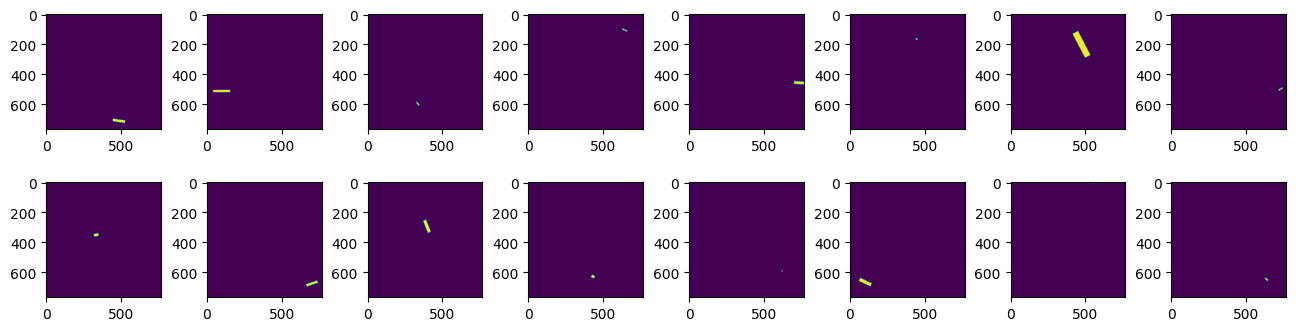

In [14]:
# Plot some masks
w = 8
h = 2

df = df[~df['EncodedPixels'].isna()]

_, axes_list = plt.subplots(h, w, figsize=(2*w, 2*h))
plt.subplots_adjust(wspace=0.4)
ax.set(xlim=(0, 768), ylim=(0, 768))
for axes in axes_list:
    for ax in axes:
        ax.axis('auto')
        canvas = np.zeros((768, 768))
        pixels = rle_to_pixels(np.random.choice(df['EncodedPixels']))
        canvas[tuple(zip(*pixels))] = 1
        ax.imshow(canvas)

In [15]:
#In some images there are more that one ship so the df has more than one row, we merge this data into one rle code
df = df.groupby("ImageId")[['EncodedPixels']].agg(lambda rle_codes: ' '.join(rle_codes)).reset_index()
load_img = lambda filename: np.array(PIL.Image.open(f"data/train_v2/{filename}"))

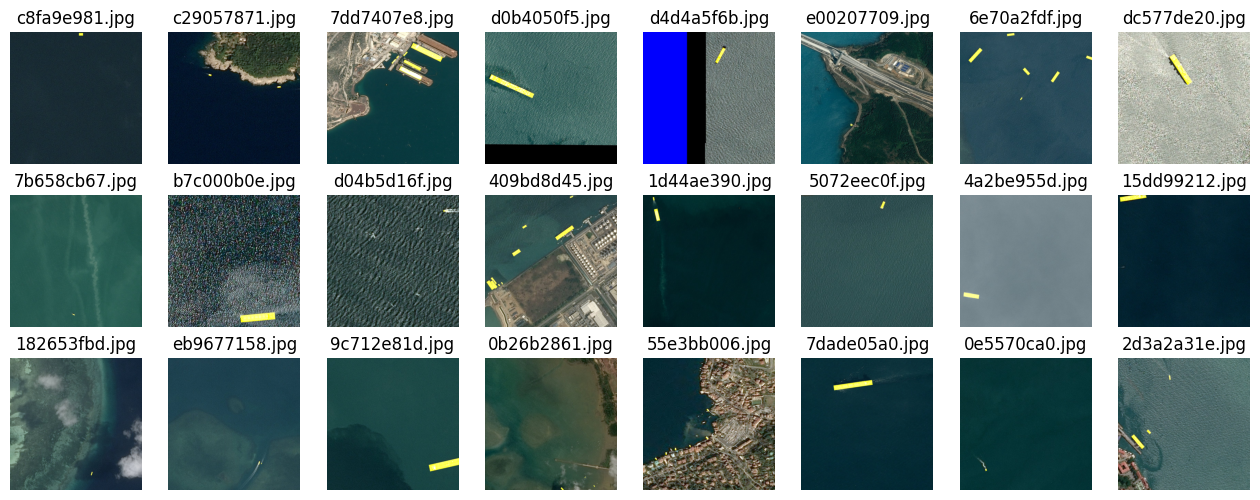

In [16]:
# Plot some images with maks
w = 8
h = 3

_, axes_list = plt.subplots(h, w, figsize=(2*w, 2*h))

for axes in axes_list:
    for ax in axes:
        ax.axis('off')
        row_index = np.random.randint(len(df)) # take a random row from the df
        ax.imshow(apply_mask(load_img(df.loc[row_index, 'ImageId']), rle_to_pixels(df.loc[row_index, 'EncodedPixels'])))
        ax.set_title(df.loc[row_index, 'ImageId'])